Add the package to the path.

In [12]:
import sys
sys.path.append("C:/Users/A.C.EA/OneDrive/Documents/GitHub/QMPRS")
sys.path.append("C:/Users/A.C.EA/OneDrive/Documents/GitHub/QICKIT")

Import `qmprs` modules. For this demo, we will import the MPS instance.

In [13]:
from qmprs.mps import MPS
from qmprs.synthesis.mps_encoding import Sequential

We will also import some basic modules for additional calculations.

In [14]:
import numpy as np

### MPS Demo : Creating and manipulating Matrix Product States (MPS)

This notebook is dedicated to the demonstration of how `qmprs` can be used to create and manipulate matrix product states (MPS). In this notebook, we will go over the main functionalities of the `MPS` class and how it can be used at the high level to perform conventional MPS operations. This will set the intuition for how MPS can be used in gate-based quantum computing applications to perform state preparation or unitary synthesis.

At a high level, MPS [[3]] can be understood as an approximation of a tensor network where we represent the approximation as the product of a series of matrices. This is useful for quantum computing where we represent quantum states as 1D tensors, and quantum operators as matrices operating on 1D tensors. We can use MPS to approximate a given quantum state (and similarly a Matrix Product Operator (MPO) to approximate a quantum operator) given some measure $\chi$ called the bond dimension, whereby increasing the bond dimension we can reach higher fidelity approximations but at the cost of larger matrices. Conventionally, the cost of an MPS is as follows:

Circuit depth = $O(dN\chi^2)$

Where $d$ is the physical dimension of the state (which is equal to 2 for qubit-based representation), and $N$ is the number of qubits required to represent the state. At a glance, one can infer that given a constant bond dimension the cost of preparing the state scales linearly with the number of qubits, which is an exponential reduction compared to the usual exact encoding schema seen in [[1]] and [[2]].

[1]: https://
[2]: https://
[3]: https://

Below is an example of how we can create an MPS for some arbitrary quantum state. For ease in assessing the fidelity of the MPS, we will use images and compare the original image with the extracted image after constructing the MPS, and calculate the fidelity of the two using a simple inner product. For this example, we will use a Fashion MNIST datapoint.

In [15]:
# Load the test image
import pandas as pd

# Load in the resized MNIST dataset
dataset = pd.read_csv('C:/Users/A.C.EA/OneDrive/Documents/GitHub/QMPRS/notebooks/datasets/mnist-resized.csv')

# Convert the dataset to a numpy array
images = dataset.to_numpy()[:,1:].reshape(30018, 8, 8)

# Get the first image
test_image = images.reshape(30018, 8, 8)[0, :]

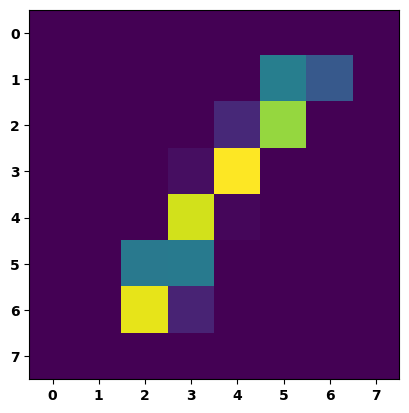

In [16]:
import matplotlib.pyplot as plt

plt.imshow(test_image)

Next, we will convert this image to a quantum state using `qickit.data.Data`'s `.to_quantumstate()` method. `qmprs` is built with `qickit` in mind, hence a great amount of the package utilizes the codebase built in `qickit`.

In [17]:
from qickit.data import Data

# Create a `qickit.data.Data` instance
state = Data(test_image)
state.to_quantumstate()

# Create a `qmprs.mps.MPS` instance
mps = MPS(statevector=state, bond_dimension=32)

We can then reconstruct the state vector using `.to_statevector()` method.

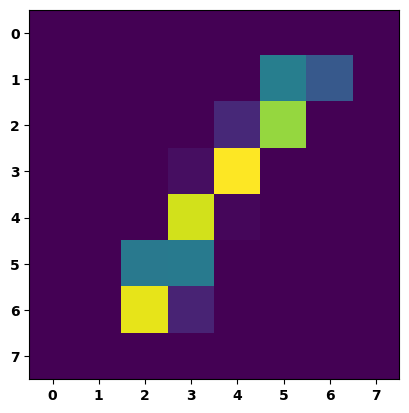

In [18]:
state = MPS.to_statevector(mps.mps)

plt.imshow(state.data.reshape(8, 8))

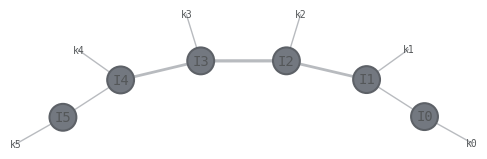

MatrixProductState(tensors=6, indices=11, L=6, max_bond=5)

In [19]:
mps.draw()

mps.mps

In [20]:
from qickit.circuit import QiskitCircuit

sequential_encoder = Sequential(QiskitCircuit)
circuit = sequential_encoder.prepare_mps(mps, num_layers=32)

In [21]:
statevector = circuit.get_statevector()

print(statevector)

[-1.73507086e-04 -2.33079220e-04 -2.75026509e-04  9.13932071e-05
 -3.06545662e-04  2.40520005e-05  4.81755609e-05 -1.93197909e-04
 -1.94134354e-04  9.75761653e-05  9.92757545e-05  1.12568378e-04
 -1.12874309e-04 -2.10409503e-01 -1.37124113e-01 -2.26933741e-04
 -1.25842256e-04 -1.81847018e-04  1.55490291e-04  2.67080035e-04
  5.61810912e-02  4.15724984e-01  1.45243688e-04  3.29001785e-04
 -3.13775262e-04 -1.75366340e-04 -5.41084194e-05 -1.76113380e-02
 -4.92632904e-01  2.46518715e-04 -3.39818624e-04 -2.33505311e-04
  8.76887348e-05 -1.02809728e-04  2.18937875e-04 -4.58477825e-01
  7.71792742e-03  4.77434880e-05 -3.11562135e-04 -2.29363674e-04
 -1.99039399e-04  1.97565550e-04 -1.98782145e-01  2.00195018e-01
 -1.79846090e-04 -2.61274147e-04  3.22577778e-04 -6.31854653e-05
 -2.08331958e-04  4.11174463e-05  4.75146670e-01  4.82020493e-02
 -1.79278405e-04  1.74733791e-04  2.34953963e-04  2.75533568e-04
 -1.74113999e-04 -2.02368174e-04 -1.38371904e-04 -1.13632735e-04
 -9.00323169e-05 -4.10974

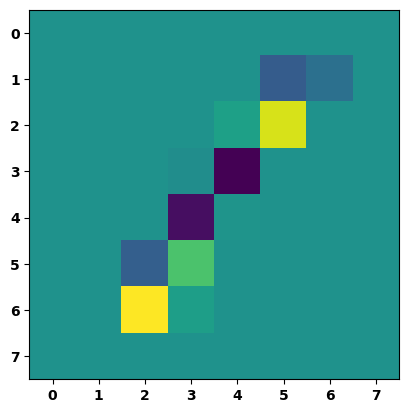

In [22]:
import matplotlib.pyplot as plt

plt.imshow(statevector.reshape(8, 8))